# Evaluate how hydroelectric generation infrastructure influences the decarbonization trajectories in developing & developed countries differently through the mechanism of transmission and distribution losses discrepancy (2000-2021)
## 1. Introduction
The transition to a low-carbon economy is a defining challenge, with hydroelectricity often cited as a key solution for the developing world. Theoretically, hydropower offers industrialization without the West's historical carbon footprint. However, empirical trends suggest a disconnect between this potential and environmental outcomes. This project investigates the "Hydro-Decarbonization Paradox": Does possessing hydroelectric capacity (X) automatically reduce electricity sector carbon intensity (Y), or is this relationship mediated by grid integration (Z)? We hypothesize that while developing nations possess superior resources, structural deficiencies in transmission prevent them from achieving decarbonization.

Literature reveals a complex narrative. Bhattarai (2017) finds that hydroelectricity reduces emissions long-term. However, others emphasize disruptions. Herrera-Estrada et al. (2018) identify a "substitution effect," where Droughts can force operators to dispatch fossil fuel backups, spiking emissions (Herrera-Estrada et al., 2018). Challenging the "zero-carbon" assumption itself,Li et al. (2022) even find that reservoirs in tropical climates can emit biogenic methane. Most relevant is Rodríguez-Sarasty et al. (2021), who emphasize that hydro capacity is insufficient without deep market integration and transmission infrastructure to displace fossil fuels. Our project builds on this by quantifying the "integration gap" between the Global North and South.

To analyze this, we constructed a panel dataset covering global economies from 2000 to 2021. Our analysis reveals three key patterns. First, a "Great Divergence," where developing nations remain stagnant in decarbonization despite significant hydro potential. Second, a "Hydro-Decarbonization Paradox," where the correlation between hydro adoption and carbon reduction is notably weaker in the developing world. Third, a critical "Efficiency Gap," where high transmission losses create a "leakage effect" that erodes the environmental benefits of this natural resource endowment.

## 2. Data Cleaning/Loading
To test our hypothesis, we consolidate the Emissions by Country (Kaggle, our original dataset), OWID Energy Data (Our World in Data, external) and Electric Power Transmission and Distribution Losses (World Bank Group, external) to facilitate our analysis. The WBG dataset provides the variable transmission loss, and the OWID Energy dataset provides important variables such as traditional and renewable energy generation, carbon intensity and GDP. 

In [2]:
import pandas as pd
import numpy as np

df_emissions = pd.read_csv('/Users/kunwuxue/Desktop/ECO225/archive/GCB2022v27_MtCO2_flat.csv')
df_energy = pd.read_excel('/Users/kunwuxue/Desktop/ECO225/archive/owid-energy-data.xlsx')
df_loss = pd.read_excel('/Users/kunwuxue/Desktop/ECO225/archive/API_EG.ELC.LOSS.ZS_DS2_en_excel_v2_22.xlsm')

After loading the data, we merge the datasets based on the country's iso code and year of observation. Because the format of Electric Power Transmission and Distribution Losses is different from others, we need to clean and reformat the dataset for the merge.

In [3]:
df_emissions = df_emissions.rename(columns={'ISO 3166-1 alpha-3': 'iso_code', 'Year': 'year'})
year_cols = [str(y) for y in range(1960, 2025) if str(y) in df_loss.columns]
cols_to_melt = ['Country Code'] + year_cols
df_loss_clean = df_loss[cols_to_melt].melt(
    id_vars=['Country Code'], 
    var_name='year', 
    value_name='transmission_loss_pct'
)
df_loss_clean = df_loss_clean.rename(columns={'Country Code': 'iso_code'})
df_loss_clean['year'] = pd.to_numeric(df_loss_clean['year'])

After pre-processing the data, we do a two-step merge to merge the three datasets by using "left" merge on ISO code and year. We then filter the columns only to the ones we need for analysis, including important indicators such as total electricity generation, total hydroelectricity generation, carbon intensity, and transmission loss percentage etc. Also, we drop the observations that are not for countries and therefore have no ISO code.

In [4]:
merged_df = pd.merge(
    df_emissions,
    df_energy,
    on=['iso_code', 'year'],
    how='inner',
)
merged_df = pd.merge(
    merged_df,
    df_loss_clean,
    on=['iso_code', 'year'],
    how='left'
)
cols_to_keep = [
    'iso_code', 'year', 'country',                
    'Total',                  
    'Coal', 'Gas',                    
    'electricity_generation',      
    'hydro_electricity',      
    'solar_electricity',      
    'wind_electricity',       
    'carbon_intensity_elec',
    'gdp',                        
    'primary_energy_consumption', 
    'population',
    'transmission_loss_pct'
]
valid_cols = [c for c in cols_to_keep if c in merged_df.columns]
df_clean = merged_df[valid_cols].copy()
df_clean = df_clean.dropna(subset=['iso_code'])

To make our dataset more readable, we rename the columns as follows. Also, to specify the level of development of all countries, we list the developed countries' ISO code and add the "status" column to each country. The countries are divided into developed and developing according to the standard of the United Nations. The merged dataset covers the period 2000-2021 as we only focus on this period, with some variables unavailable in certain periods due to a lack of statistics.

In [5]:
df_clean = df_clean.rename(columns={
    'Total': 'co2_total',
    'Coal': 'co2_coal',
    'Gas': 'co2_gas',
    'electricity_generation': 'total_generation_twh',
    'hydro_electricity': 'hydro_generation_twh',
    'solar_electricity': 'solar_generation_twh',
    'wind_electricity': 'wind_generation_twh',
    'carbon_intensity_elec': 'carbon_intensity',
    'primary_energy_consumption': 'total_energy_twh'
}) 

developed_isos = [
    'USA', 'CAN', 'GBR', 'FRA', 'DEU', 'ITA', 'JPN', 'AUS', 'NZL', 
    'AUT', 'BEL', 'CHE', 'DNK', 'ESP', 'FIN', 'GRC', 'HKG', 'IRL', 
    'ISL', 'ISR', 'KOR', 'LUX', 'NLD', 'NOR', 'PRT', 'SGP', 'SWE', 'TWN'
]

def classify_country(iso):
    if iso in developed_isos:
        return 'Developed'
    return 'Developing'

df_clean['status'] = df_clean['iso_code'].apply(classify_country)

df_final = df_clean[(df_clean['year'] >= 2000) & (df_clean['year'] <= 2021)].copy()

In the final step, we calculate other X variables that are necessary for our analysis from existing columns and add them to the dataset, including CO2 per GDP, electrification rate, hydroelectricity share, solar and wind electricity share, and GDP per capita. We then save the file locally for future use.

In [6]:
if 'gdp' in df_final.columns:
    df_final['co2_per_gdp_kg'] = (df_final['co2_total'] * 1e9) / df_final['gdp']

if 'total_energy_twh' in df_final.columns:
    df_final['electricity_share_energy'] = (df_final['total_generation_twh'] / df_final['total_energy_twh']) * 100
df_final['electricity_share_energy'] = df_final['electricity_share_energy'].replace([np.inf, -np.inf], np.nan)

df_final['hydro_share_pct'] = (df_final['hydro_generation_twh'] / df_final['total_generation_twh']) * 100
df_final['solar_generation_twh'] = df_final['solar_generation_twh'].fillna(0)
df_final['wind_generation_twh'] = df_final['wind_generation_twh'].fillna(0)

df_final['solar_wind_share_pct'] = (
    (df_final['solar_generation_twh'] + df_final['wind_generation_twh']) / df_final['total_generation_twh']
) * 100
df_final['gdp_per_capita'] = df_final['gdp'] / df_final['population']

df_final = df_final[df_final['carbon_intensity'] > 0]
df_final.to_csv('/Users/kunwuxue/Desktop/ECO225/archive/my_merged_data.csv', index=False)

## 3. Summary Statistics Tables


In [7]:
from IPython.display import display, HTML

cols_to_keep = [
    'carbon_intensity', 
    'co2_per_gdp_kg',
    'hydro_share_pct', 
    'transmission_loss_pct', 
    'gdp_per_capita', 
    'electricity_share_energy', 
    'solar_wind_share_pct'
]

labels = {
    'carbon_intensity': 'Grid Carbon Intensity (gCO2/kWh)',
    'co2_per_gdp_kg': 'Economic Carbon Intensity (kgCO2/$)',
    'hydro_share_pct': 'Hydro Share (%)',
    'transmission_loss_pct': 'Grid Losses (%)',
    'gdp_per_capita': 'GDP per Capita ($)',
    'electricity_share_energy': 'Electricity Share of Energy (%)',
    'solar_wind_share_pct': 'Solar+Wind Share (%)'
}

def create_summary_table(df, status_name):
    subset = df[df['status'] == status_name][cols_to_keep].rename(columns=labels)
    
    stats = subset.describe().T[['count', '50%', 'mean', 'std', 'min', 'max']]
    stats.columns = ['N', 'Median','Mean', 'Std. Dev.', 'Min', 'Max']
    
    html_style = stats.style.format("{:.2f}") \
        .set_caption(f"Table: Summary Statistics - {status_name} Nations") \
        .set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'), 
                ('font-weight', 'bold'), 
                ('font-size', '16px'),
                ('text-align', 'center'),
                ('padding-bottom', '10px')
            ]
        }]) \
        .to_html()
    
    return html_style

html_developed = create_summary_table(df_final, 'Developed')
html_developing = create_summary_table(df_final, 'Developing')

display(HTML(html_developed))
display(HTML("<br>")) 
display(HTML(html_developing))

,N,Median,Mean,Std. Dev.,Min,Max
Grid Carbon Intensity (gCO2/kWh),616.00,426.83,386.93,239.19,25.13,866.50
Economic Carbon Intensity (kgCO2/$),616.00,0.24,0.25,0.10,0.06,0.51
Hydro Share (%),616.00,7.18,20.34,26.94,0.00,99.51
Grid Losses (%),594.00,5.38,5.62,1.89,0.90,10.80
GDP per Capita ($),616.00,38767.43,41003.28,11595.22,20730.63,86353.72
Electricity Share of Energy (%),616.00,16.37,16.63,5.16,1.08,32.52
Solar+Wind Share (%),616.00,2.15,6.51,9.72,0.00,61.27


,N,Median,Mean,Std. Dev.,Min,Max
Grid Carbon Intensity (gCO2/kWh),3898.00,556.74,489.78,245.25,17.24,1306.72
Economic Carbon Intensity (kgCO2/$),2989.00,0.23,0.29,0.23,0.00,2.05
Hydro Share (%),3879.00,11.88,26.90,31.92,0.00,100.00
Grid Losses (%),2601.00,13.38,15.80,10.73,1.14,89.73
GDP per Capita ($),2989.00,7463.09,11238.24,14444.89,421.56,163531.40
Electricity Share of Energy (%),3850.00,13.80,16.77,19.22,0.23,284.71
Solar+Wind Share (%),3898.00,0.00,1.53,4.17,0.00,50.00


The descriptive statistics substantiate the "Hydro-Decarbonization Paradox" by revealing a sharp disconnect between resource potential and structural efficiency. In terms of endowment, the Hydro Share confirms the Developing group's advantage, displaying a higher mean and a maximum value that reaches 100% (reflecting hydro-dominant nations). However, the Economic Carbon Intensity data challenges the assumption that developing economies are uniformly "dirty." In fact, the Median developing nation is actually more carbon-efficient (0.23 kg/USD) than the median developed nation (0.24 kg/USD). The critical difference lies in volatility: the Standard Deviation for the Developing group (0.23) is more than double that of the Developed group (0.10). This indicates that while the "typical" hydro-rich developing nation is relatively clean, the group is plagued by a "fat tail" of extremely inefficient outliers that drag down its collective performance.

The data further identifies the mechanisms driving this inconsistency. The Transmission Losses variable shows that the Developing group suffers from significantly higher average grid wastage compared to the Developed group, confirming that infrastructure quality is a binding constraint. Additionally, the Electricity Share of Energy highlights an "Integration Gap." While the Developed group is tightly clustered around a mean of ~16% (Low SD: 5.16), indicating a consistent structural reliance on electricity, the Developing group shows massive variation (High SD: 19.22) with a lower median (13.80%). This suggests that despite having the dams to generate power, many developing nations lack the deep grid integration required to displace fossil fuels in the broader economy.

## 4. Plots, Histograms, Figures

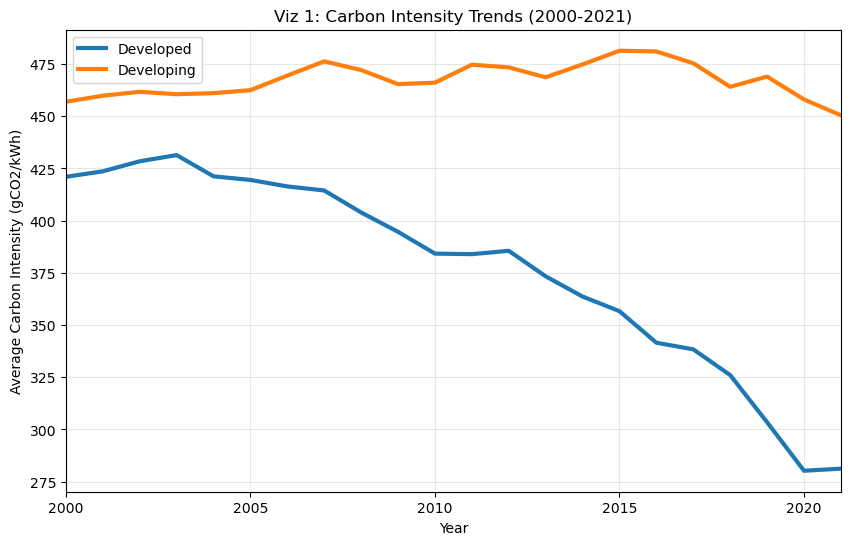

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = df_final.dropna(subset=['hydro_share_pct', 'carbon_intensity', 'transmission_loss_pct', 'status']).copy()
colors = {'Developed': '#1f77b4', 'Developing': '#ff7f0e'} 

fig1, ax1 = plt.subplots(figsize=(10, 6))

trend_data = df.groupby(['year', 'status'])['carbon_intensity'].mean().unstack()

ax1.plot(trend_data.index, trend_data['Developed'], 
         color=colors['Developed'], linewidth=3, label='Developed')

ax1.plot(trend_data.index, trend_data['Developing'], 
         color=colors['Developing'], linewidth=3, label='Developing')

ax1.set_title('Viz 1: Carbon Intensity Trends (2000-2021)')
ax1.set_ylabel('Average Carbon Intensity (gCO2/kWh)')
ax1.set_xlabel('Year')

start_year = int(trend_data.index.min())
end_year = int(trend_data.index.max())
ax1.set_xticks(np.arange(start_year, end_year + 1, 5)) 
ax1.set_xlim(start_year, end_year)

ax1.legend()
ax1.grid(True, alpha=0.3)

### Visualizarion 1
Our first visualization shows the trend of carbon intensity for both develoepd and developing countries from 2000 to 2021. The line graph shows that while the average carbon intensity (gCO2/kWh) of developed countries (orange line) kept flat during the period, that of developed economies (blue line) sigificantly dropped. This shows a huge divergence between the decarbonizaiton trajectories of developed and developing nations. The stagnation for developing nations suggests that despite the global push for renewables, structural or economic barriers in these nations are preventing the same rapid decarbonization, even as they potentially bring new renewable capacity online. This "decarbonization gap" sets the context for investigating the underlying inefficiencies in the subsequent figures.

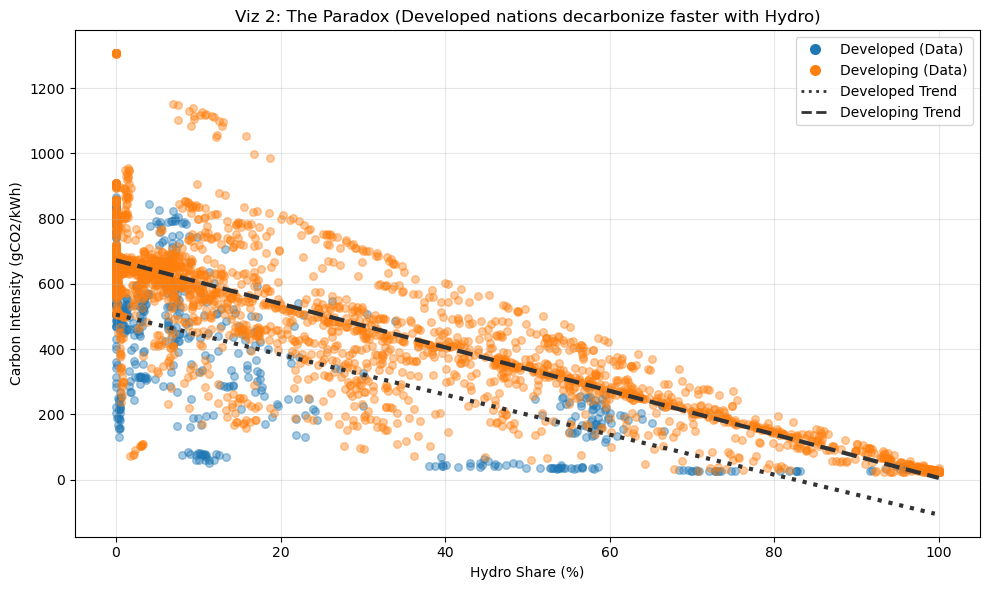

In [16]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
line_styles = {'Developed': ':','Developing': '--'}

for status in ['Developed', 'Developing']:
    subset = df[df['status'] == status]
    # Plot Dots (No label here, we add it manually later)
    ax2.scatter(subset['hydro_share_pct'], subset['carbon_intensity'], 
                color=colors[status], alpha=0.4, s=30)
    
    # Plot Trendline (No label here)
    z = np.polyfit(subset['hydro_share_pct'], subset['carbon_intensity'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(subset['hydro_share_pct'].min(), subset['hydro_share_pct'].max(), 100)
    ax2.plot(x_range, p(x_range), color='#333333', linewidth=3, linestyle=line_styles[status])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Developed (Data)',
           markerfacecolor=colors['Developed'], markersize=9),
    Line2D([0], [0], marker='o', color='w', label='Developing (Data)',
           markerfacecolor=colors['Developing'], markersize=9),
    Line2D([0], [0], color='#333333', lw=2, linestyle=':', label='Developed Trend'),
    Line2D([0], [0], color='#333333', lw=2, linestyle='--', label='Developing Trend')
]
ax2.legend(handles=legend_elements, loc='upper right')

ax2.set_title('Viz 2: The Paradox (Developed nations decarbonize faster with Hydro)')
ax2.set_xlabel('Hydro Share (%)')
ax2.set_ylabel('Carbon Intensity (gCO2/kWh)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualization 2
The second graph further visualizes our core research question by comparing the elasticity of carbon intensity with respect to hydropower adoption between the groups. Although both trend lines show a negative slope, which means higher share of hydroelectricity is correlated with lower carbon intensity generally, the level of carbon intensity at the same share of hydro level is on average lower in the developed nations. This mathematically represents the Paradox: for every 1% increase in hydro share, a developing nation achieves a significantly smaller reduction in carbon intensity than a developed one. The wide dispersion of the orange dots further highlights that simply having hydro resources does not guarantee a low-carbon outcome in the absence of complementary infrastructure.

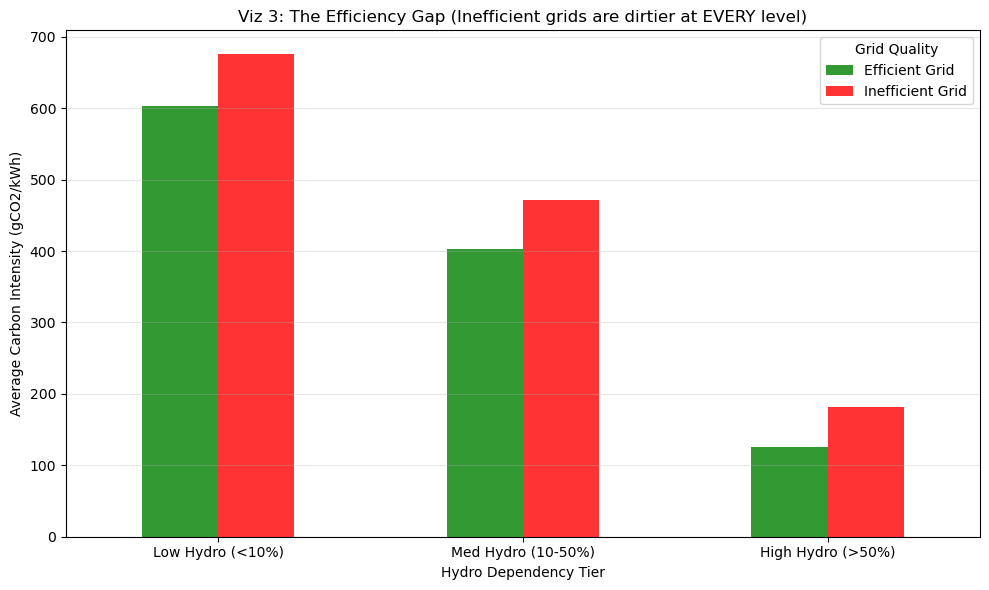

In [17]:
fig3, ax3 = plt.subplots(figsize=(10, 6))

df['Hydro_Tier'] = pd.cut(df['hydro_share_pct'], 
                          bins=[-1, 10, 50, 100], 
                          labels=['Low Hydro (<10%)', 'Med Hydro (10-50%)', 'High Hydro (>50%)'])

median_loss = df['transmission_loss_pct'].median()
df['Grid_Type'] = np.where(df['transmission_loss_pct'] < median_loss, 'Efficient Grid', 'Inefficient Grid')

bar_data = df.groupby(['Hydro_Tier', 'Grid_Type'], observed=False)['carbon_intensity'].mean().unstack()

bar_data.plot(kind='bar', ax=ax3, color=['green', 'red'], alpha=0.8)

ax3.set_title('Viz 3: The Efficiency Gap (Inefficient grids are dirtier at EVERY level)')
ax3.set_ylabel('Average Carbon Intensity (gCO2/kWh)')
ax3.set_xlabel('Hydro Dependency Tier')
ax3.grid(axis='y', alpha=0.3)
ax3.legend(title='Grid Quality')

plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

### Visualization 3
Figure 3 further support our research question by comparing the carbon intensity between countries with different grid efficiency at a fixed level of hydro dependency. Nations with Inefficient Grids (Red bars) consistently exhibit higher average carbon intensities than those with Efficient Grids (Green bars). While developing countries are not necessarily all with inefficient grid, this catergorization provides a more comprehensive overview of how transmission and distribution loss in the grid can affect a country's decarbonization trajectory. The red bars essentially visualize the "wasted potential" of hydro resources in the developing world.

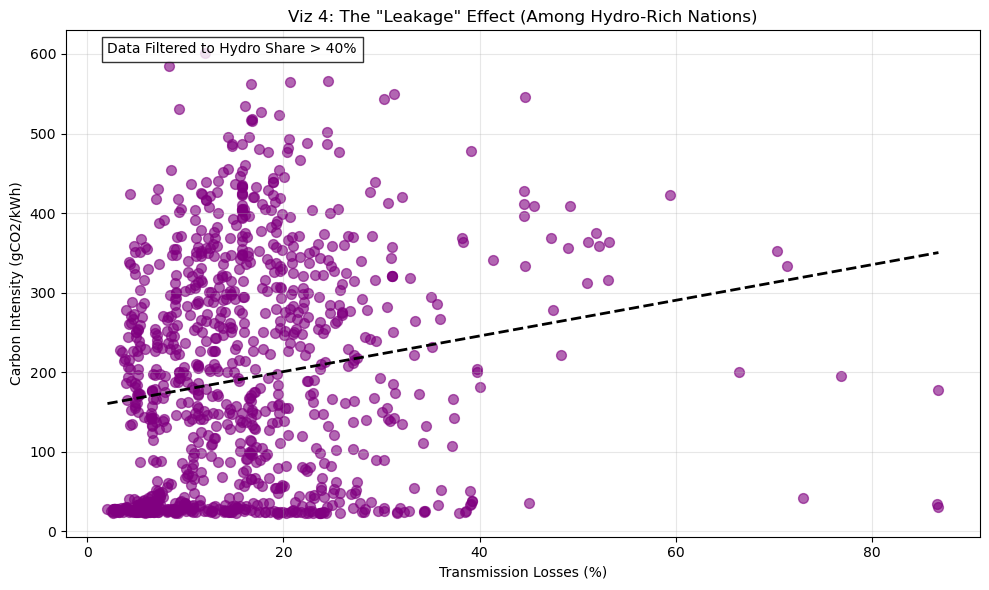

In [18]:
fig4, ax4 = plt.subplots(figsize=(10, 6))

hydro_rich = df[df['hydro_share_pct'] > 40]

ax4.scatter(hydro_rich['transmission_loss_pct'], hydro_rich['carbon_intensity'], 
            color='purple', alpha=0.6, s=50)

z = np.polyfit(hydro_rich['transmission_loss_pct'], hydro_rich['carbon_intensity'], 1)
p = np.poly1d(z)
x_range = np.linspace(hydro_rich['transmission_loss_pct'].min(), hydro_rich['transmission_loss_pct'].max(), 100)
ax4.plot(x_range, p(x_range), color='black', linestyle='--', linewidth=2)

ax4.set_title('Viz 4: The "Leakage" Effect (Among Hydro-Rich Nations)')
ax4.set_xlabel('Transmission Losses (%)')
ax4.set_ylabel('Carbon Intensity (gCO2/kWh)')
ax4.text(x=hydro_rich['transmission_loss_pct'].min(), 
         y=hydro_rich['carbon_intensity'].max(), 
         s="Data Filtered to Hydro Share > 40%", 
         bbox=dict(facecolor='white', alpha=0.8))
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualization 4
This final figure provides the strongest evidence for the "leakage" hypothesis by filtering the dataset to include only hydro-rich nations (>40% share). Theory suggests these nations should all be clustered at near-zero carbon intensity. Instead, the trendline reveals a positive relationship: as Transmission Losses increase (moving right on the X-axis), Carbon Intensity rises. This positive slope quantifies the "Leakage Effect"—where physical waste in the transmission system forces the grid to rely on backup thermal generation to meet demand, thereby nullifying the environmental benefits of the installed hydro capacity. It confirms that in high-loss grids, a significant portion of the "clean" energy is lost before it can decarbonize the economy.

## 5. Conclusion
This study investigated the "Hydro-Decarbonization Paradox" using a comprehensive dataset of national energy systems from 2000 to 2021. Our findings confirm a significant structural divergence: while developed nations demonstrate a strong correlation between hydropower adoption and reduced carbon intensity, this relationship is markedly weaker in developing nations.

Our analysis identifies grid inefficiency as the primary mechanism driving this result. We found that nations with high transmission losses consistently exhibit higher carbon intensities, regardless of their level of hydro dependency. This "Efficiency Gap" implies that without a reliable grid to transmit power, the theoretical benefits of renewable generation are lost. Most critically, we observed a "Leakage Effect" among hydro-rich nations (>40% share), where higher transmission losses were positively correlated with rising carbon intensity. This suggests that physical waste in the transmission system forces grid operators to rely on fossil fuel backups to meet demand, effectively nullifying the environmental benefits of the installed hydro capacity.

Ultimately, these findings suggest that the strategy for decarbonization in the Global South must shift. Simply building generation capacity is insufficient. To realize the full potential of their hydroelectric resources, developing nations must prioritize modernizing transmission infrastructure and deepening grid integration. Without addressing these structural inefficiencies, the promise of a low-carbon industrialization will remain out of reach.

## Reference
Ameli, N., Dessens, O., Winning, M., Cronin, J., Chenet, H., Drummond, P., ... & Grubb, M. (2021). _Higher cost of finance for renewable energy in developing countries._ Nature Energy, 6(12), 1223-1232.

Bhattarai, K. (2017). _Environmental Kuznets Curve for carbon emissions in Nepal: The role of hydroelectricity._ International Journal of Energy Economics and Policy, 7(4), 216-222.

Herrera-Estrada, J. E., Diffenbaugh, N. S., Wagner, F., Craft, A., & Sheffield, J. (2018). _Response of electricity sector air pollution emissions to drought conditions in the western United States._ Environmental Research Letters, 13(12), 124032.

Li, M., Zhang, B., Wang, S., & Liu, J. (2022). _Carbon intensity of global existing and future hydropower reservoirs._ Renewable and Sustainable Energy Reviews, 162, 112433.

Rodríguez-Sarasty, J. A., Debia, S., & Pineau, P. O. (2021). _Deep decarbonization in Northeastern North America: The value of electricity market integration and hydropower._ Energy Policy, 152, 112210.